In [1]:
!pip install phonemizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 17.1 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=50d49b77533d7ef38e55a2dfde8bfa75ea50a8236aba98c4f1a1643754c2782f
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [3]:
import torch

In [4]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow')

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [5]:
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
from tacotron2.text import text_to_sequence
from waveglow.denoiser import Denoiser

/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/text/__init__.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [6]:
tacotron2 = tacotron2.eval().cuda()
waveglow = waveglow.eval().cuda()
denoiser = Denoiser(waveglow).cuda()

In [7]:
def preprocess_text(text):
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).cuda().long()
    input_lengths = torch.tensor([sequence.size(1)]).cuda()
    return sequence, input_lengths

In [8]:
def text_to_speech(text):
    # Preprocess the text
    sequence, input_lengths = preprocess_text(text)

    # Generate mel spectrogram
    with torch.no_grad():
        mel_outputs_postnet, mel,alignments = tacotron2.infer(sequence, input_lengths)

    # Synthesize audio using WaveGlow
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet)

    # Denoise the audio
    audio = denoiser(audio, strength=0.01)[:, 0]

    return audio, mel_outputs_postnet

In [9]:
text = "This is part of the Natural Language Processing for Speech and Text course on Linkedin Learning"
audio, mel = text_to_speech(text)

In [10]:
import IPython.display as ipd
ipd.Audio(audio.cpu().numpy(), rate=22050)

In [11]:
torchaudio.save('output.wav', audio.cpu(), 22050)

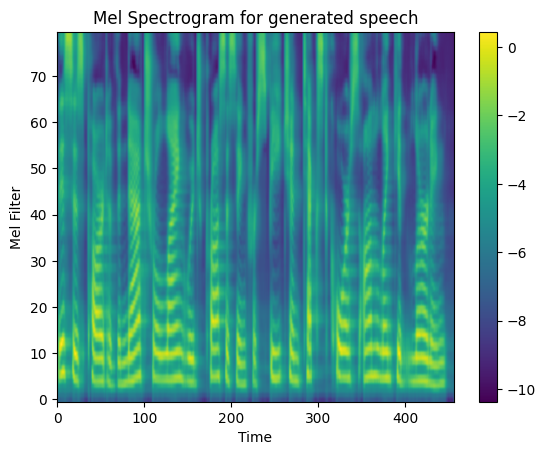

In [12]:
plt.imshow(mel[0].cpu().numpy(), aspect='auto', origin='lower')
plt.xlabel('Time')
plt.ylabel('Mel Filter')
plt.colorbar()
plt.title('Mel Spectrogram for generated speech')
plt.show()